## Autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
import ipywidgets as widgets
from IPython.display import display

## Parameters

### Import acceleration data file

**File location**

In [3]:
notebook_location = pathlib.Path().absolute()
parent_directory = notebook_location.parent
data_folder = parent_directory / 'tests/test_data'
file_name = 'acceleration.txt'
file_location = data_folder / file_name
print(data_folder)

sampling_rate = 100

c:\Users\ingah\estructuraPy\epy_signal_proccessing\tests\test_data



**Import acceleration data**

In [4]:
def process_acceleration_data(file_location: str) -> pd.DataFrame:
    """
    Processes acceleration data from a file and returns a Pandas DataFrame.

    Args:
        file_location: The path to the file containing the acceleration data.

    Returns:
        A Pandas DataFrame containing the time and acceleration data.

    Assumptions:
        - The file exists and is readable.
        - The file encoding is 'latin1'.
        - The file contains at least two lines, with the second line being a header.
        - Each data line has at least 10 fields, with the 2nd, 3rd, and 4th fields representing x, y, and z accelerations respectively.
    """
    with open(file_location, 'r', encoding='latin1') as file:
        lines = [line.strip() for line in file.readlines()[1:]]  # Reads lines and skips the header
    times = []
    x_accelerations = []
    y_accelerations = []
    z_accelerations = []

    for line in lines:
        fields = line.split()
        if len(fields) >= 5:  # Checks if the line has enough fields
            try:
                time = float(fields[1])
                x_acceleration = float(fields[2])
                y_acceleration = float(fields[3])
                z_acceleration = float(fields[4])

                times.append(time)
                x_accelerations.append(x_acceleration)
                y_accelerations.append(y_acceleration)
                z_accelerations.append(z_acceleration)
            except ValueError:
                print(f"Skipping line due to invalid data: {line}")  # Error: Handles potential conversion errors

    times = np.array(times)
    x_accelerations = np.array(x_accelerations)
    y_accelerations = np.array(y_accelerations)
    z_accelerations = np.array(z_accelerations)

    return pd.DataFrame({
        'Time': times,
        'X Acceleration': x_accelerations,
        'Y Acceleration': y_accelerations,
        'Z Acceleration': z_accelerations
    })

In [5]:
df = process_acceleration_data(file_location)

Skipping line due to invalid data: POSITION       Time             ATb1116X         ATb1116Y         ATb1116Z         IW4-0778-0-CHAN-4ATb1106X         ATb1106Y         ATb1106Z         IW4-0777-0-CHAN-4


In [6]:
df

,Time,X Acceleration,Y Acceleration,Z Acceleration
0,0.01,-0.000169,-0.001170,-0.001292
1,0.02,-0.000088,-0.000844,-0.001239
2,0.03,-0.000051,-0.000383,-0.001214
3,0.04,-0.000218,-0.000874,-0.001648
4,0.05,-0.000159,-0.000841,-0.001586
...,...,...,...,...
67103,671.04,0.000054,-0.000344,0.000950
67104,671.05,0.000043,-0.000316,0.001028
67105,671.06,0.000116,-0.000350,0.000916
67106,671.07,0.000193,-0.000417,0.000813


## FFT analysis

In [7]:
def plot_fft(fft_data: pd.DataFrame) -> np.ndarray:
    """
    Calculates the FFT of a single acceleration data column.

    Args:
        acceleration_data: Pandas Series containing acceleration data.
        sampling_rate: Sampling rate of the acceleration data.

    Returns:
        A NumPy array containing the FFT of the acceleration data.

    Assumptions:
        - 'acceleration_data' is a pandas Series of numerical values.
        - 'sampling_rate' is a positive numerical value.
    """
    frequencies = fft_data['Frequency']
    magnitudes = fft_data['Magnitude']

    # Plotting the FFT Magnitude Spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies[:], magnitudes[:] / max(magnitudes[:]))  # Plot only the positive frequencies
    plt.title('FFT Normalized Magnitude Spectrum ')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

In [8]:
def calculate_fft(acceleration_data: pd.Series, sampling_rate: float) -> np.ndarray:
    """
    Calculates the FFT of a single acceleration data column.

    Args:
        acceleration_data: Pandas Series containing acceleration data.
        sampling_rate: Sampling rate of the acceleration data.

    Returns:
        A NumPy array containing the FFT of the acceleration data.

    Assumptions:
        - 'acceleration_data' is a pandas Series of numerical values.
        - 'sampling_rate' is a positive numerical value.
    """
    n = len(acceleration_data)
    fft_data = np.fft.fft(acceleration_data)
    frequencies = np.fft.fftfreq(n, 1 / sampling_rate)
    magnitudes = np.abs(fft_data)

    # Create a DataFrame with frequencies and magnitudes (only positive frequencies)
    df_fft = pd.DataFrame({'Frequency': frequencies[:n//2], 'Magnitude': magnitudes[:n//2]})

    plot_fft(df_fft)
    
    return df_fft

In [9]:
def fft_results(acceleration_data_x: pd.Series, acceleration_data_y: pd.Series,acceleration_data_z: pd.Series, sampling_rate: float) -> pd.DataFrame:
    """
    Calculates and combines FFT results for X, Y, and Z acceleration data into a single DataFrame.

    Args:
        df: DataFrame with 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        sampling_rate: Sampling rate of the acceleration data.

    Returns:
        A Pandas DataFrame with combined FFT results for all three axes, including 'Frequency', 'Magnitude', and 'Axis' columns.

    Assumptions:
        - 'df' contains 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        - Acceleration data is in numerical format.
        - 'sampling_rate' is a positive numerical value.
    """
    fft_x = calculate_fft(acceleration_data_x, sampling_rate)
    fft_y = calculate_fft(acceleration_data_y, sampling_rate)
    fft_z = calculate_fft(acceleration_data_z, sampling_rate)

    combined_fft = pd.concat([fft_x, fft_y, fft_z], ignore_index=True)
    return combined_fft

In [10]:
# Crea un gráfico con tres líneas que representan las aceleraciones en X, Y y Z
def plot_acceleration(acceleration_data: pd.Series, label: str, color: str='red'):
    plt.plot(acceleration_data.index, acceleration_data, color=color, linestyle='-', label=label)
    # Configura los títulos y etiquetas del eje
    plt.title(f'Aceleraciones en {label}')
    plt.xlabel('Tiempo')
    plt.ylabel('Aceleración (m/s^2)')
    plt.legend()
    plt.show()
    

In [11]:
def preprocess_data(df):
    # Remove outliers (example: values beyond 3 standard deviations)
    for axis in ['Time', 'X Acceleration', 'Y Acceleration', 'Z Acceleration']:
        mean = df[axis].mean()
        std = df[axis].std()
        df[axis] = np.where(np.abs(df[axis] - mean) <= 3 * std, df[axis], mean)

    # Detrend the data
    df['Time'] = df['Time']
    df['X Acceleration baseline corrected'] = detrend(df['X Acceleration'])
    df['Y Acceleration baseline corrected'] = detrend(df['Y Acceleration'])
    df['Z Acceleration baseline corrected'] = detrend(df['Z Acceleration'])

    return df

In [12]:
preprocess_data(df)

# plot_acceleration(acceleration_data_x, 'X', 'b')
# plot_acceleration(acceleration_data_y, 'Y', 'r')
# plot_acceleration(acceleration_data_z, 'Z', 'g')

# plot_acceleration(acceleration_data_x_corrected, 'X', 'b')
# plot_acceleration(acceleration_data_y_corrected, 'Y', 'r')
# plot_acceleration(acceleration_data_z_corrected, 'Z', 'g')

,Time,X Acceleration,Y Acceleration,Z Acceleration,X Acceleration baseline corrected,Y Acceleration baseline corrected,Z Acceleration baseline corrected
0,0.01,-0.000169,-0.001170,-0.001292,-0.000048,-0.000912,-0.001840
1,0.02,-0.000088,-0.000844,-0.001239,0.000033,-0.000587,-0.001787
2,0.03,-0.000051,-0.000383,-0.001214,0.000070,-0.000126,-0.001763
3,0.04,-0.000218,-0.000874,-0.001648,-0.000097,-0.000617,-0.002197
4,0.05,-0.000159,-0.000841,-0.001586,-0.000039,-0.000583,-0.002134
...,...,...,...,...,...,...,...
67103,671.04,0.000054,-0.000344,0.000950,0.000076,-0.000103,0.000065
67104,671.05,0.000043,-0.000316,0.001028,0.000065,-0.000076,0.000142
67105,671.06,0.000116,-0.000350,0.000916,0.000138,-0.000109,0.000031
67106,671.07,0.000193,-0.000417,0.000813,0.000214,-0.000176,-0.000073


In [13]:
acceleration_data_x = df['X Acceleration']
acceleration_data_y = df['Y Acceleration']
acceleration_data_z = df['Z Acceleration']

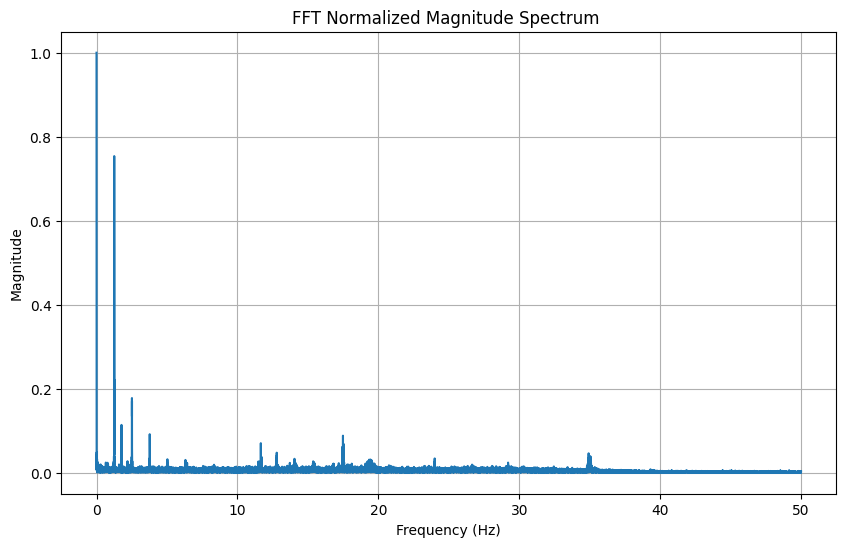

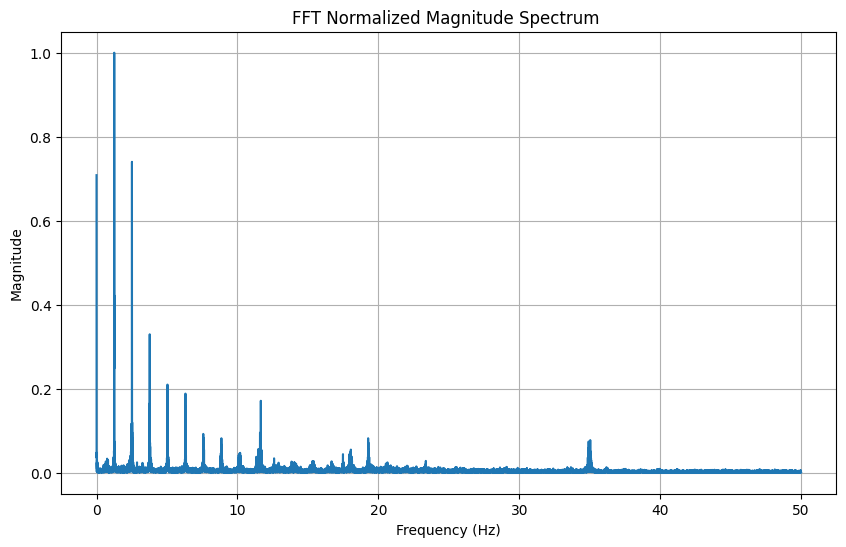

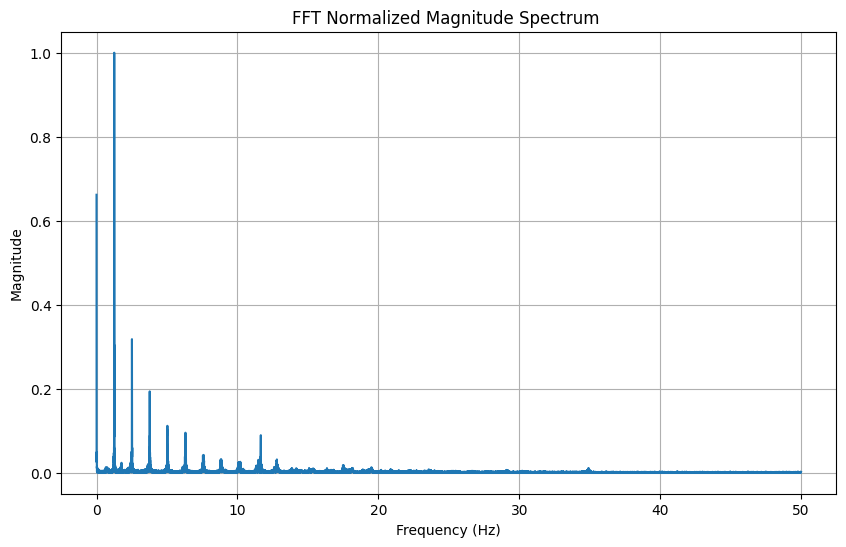

In [14]:
df_fft_results = fft_results(acceleration_data_x, acceleration_data_y, acceleration_data_z, sampling_rate)

In [15]:
acceleration_data_x_corrected = df['X Acceleration baseline corrected']
acceleration_data_y_corrected = df['Y Acceleration baseline corrected']
acceleration_data_z_corrected = df['Z Acceleration baseline corrected']

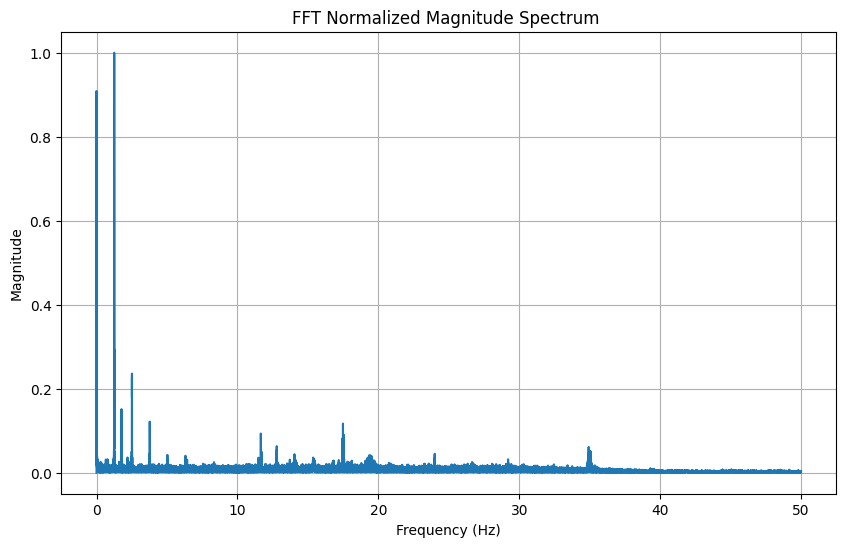

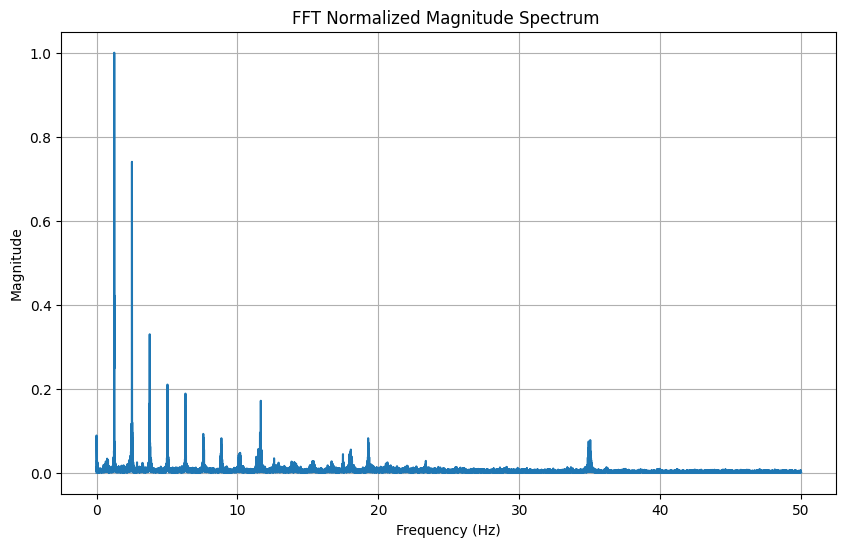

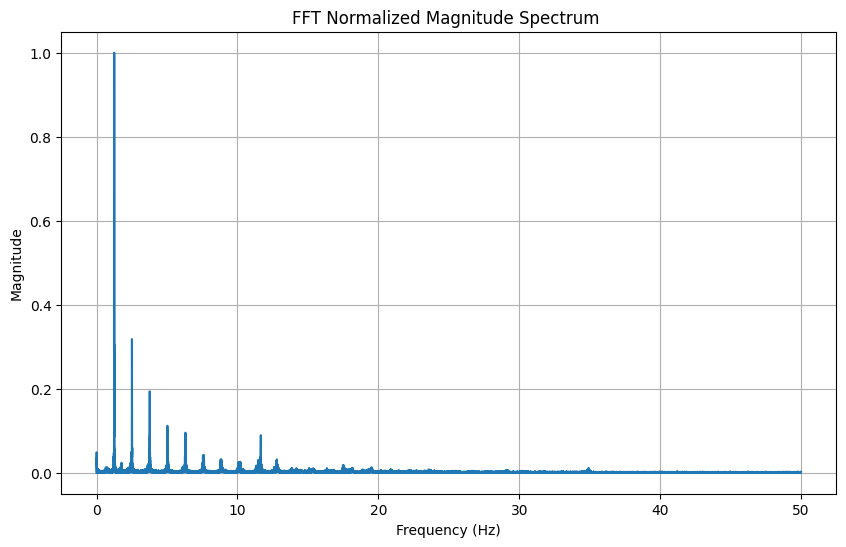

In [16]:
df_fft_results_corrected = fft_results(acceleration_data_x_corrected, acceleration_data_y_corrected, acceleration_data_z_corrected, sampling_rate)

## Filter with FFT and iFFT

In [17]:
def filter_with_fft(acceleration_data: pd.Series, sampling_rate: float, threshold_percentage: float = 5) -> pd.DataFrame:
    """
    Filters FFT output by zeroing frequencies with magnitudes below a threshold,
    and reconstructs the filtered signal.

    Args:
        df: DataFrame with 'Time', 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        threshold_percentage: Percentage of the maximum magnitude below which frequencies are filtered out.

    Returns:
        A DataFrame with filtered acceleration data.

    Assumptions:
        - 'df' contains 'Time', 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        - Time data is uniformly sampled.
        - threshold_percentage is a float between 0 and 100.
    """
    # Input validation
    if not 0 <= threshold_percentage <= 100:
        raise ValueError("threshold_percentage must be between 0 and 100.")
        
    n = len(df)
    time_step = df['Time'].iloc[1]-df['Time'].iloc[0]
    sampling_rate = 1 / time_step
    
    df_fft = fft(acceleration_data)
    magnitude = np.abs(df_fft)
    threshold = np.max(magnitude).max() * threshold_percentage / 100

    df_fft_filtered = df_fft.copy()
    df_fft_filtered[magnitude < threshold] = 0

    acceleration_data_filtered = ifft(df_fft_filtered).real

    return acceleration_data_filtered

In [18]:
threshold_percentage = 5

In [19]:
def accelerations_filtered_with_fft(acceleration_data_x: pd.Series, acceleration_data_y: pd.Series, acceleration_data_z: pd.Series, sampling_rate: float, threshold_percentage: float=10) -> pd.DataFrame:
    """
    Calculates and combines FFT results for X, Y, and Z acceleration data into a single DataFrame.

    Args:
        df: DataFrame with 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        sampling_rate: Sampling rate of the acceleration data.

    Returns:
        A Pandas DataFrame with combined FFT results for all three axes, including 'Frequency', 'Magnitude', and 'Axis' columns.

    Assumptions:
        - 'df' contains 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        - Acceleration data is in numerical format.
        - 'sampling_rate' is a positive numerical value.
    """
    df['X Filtered Acceleration'] = pd.DataFrame(filter_with_fft(acceleration_data_x, sampling_rate, threshold_percentage))
    df['Y Filtered Acceleration'] = pd.DataFrame(filter_with_fft(acceleration_data_y, sampling_rate, threshold_percentage))
    df['Z Filtered Acceleration'] = pd.DataFrame(filter_with_fft(acceleration_data_z, sampling_rate, threshold_percentage))

    return df

In [20]:
filtered_with_fft= accelerations_filtered_with_fft(acceleration_data_x_corrected, acceleration_data_y_corrected, acceleration_data_z_corrected, sampling_rate, threshold_percentage)

In [21]:
def butter_bandpass_filter(acceleration_data: pd.Series, lowcut: int=0.3, highcut: int=30, fs: int=100, order: int=4):
    """Aplica un filtro pasa-banda de Butterworth."""
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, acceleration_data)

In [22]:
filtered_acceleration_x = butter_bandpass_filter(filtered_with_fft['X Filtered Acceleration'])
filtered_acceleration_y = butter_bandpass_filter(filtered_with_fft['Y Filtered Acceleration'])
filtered_acceleration_z = butter_bandpass_filter(filtered_with_fft['Z Filtered Acceleration'])

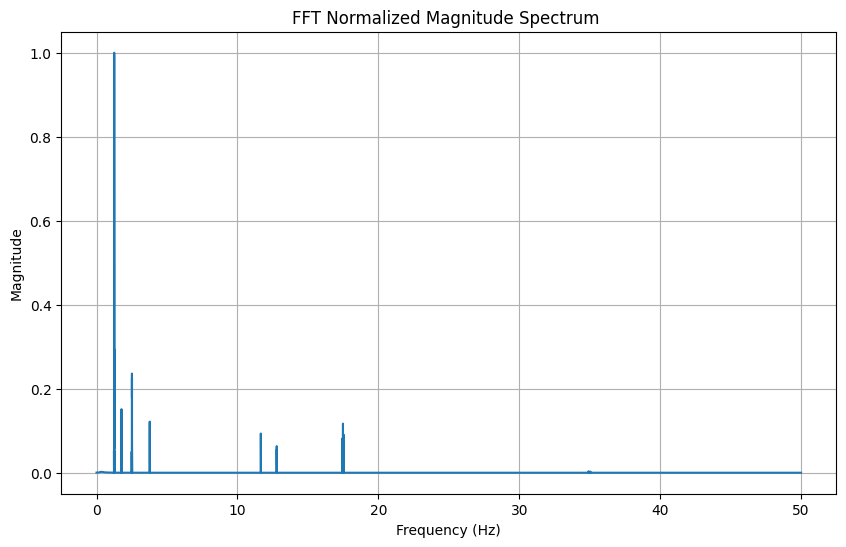

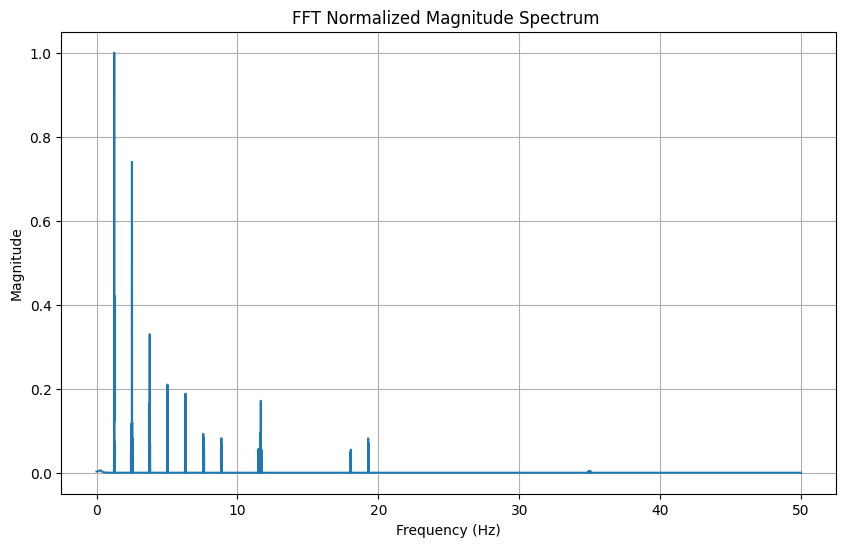

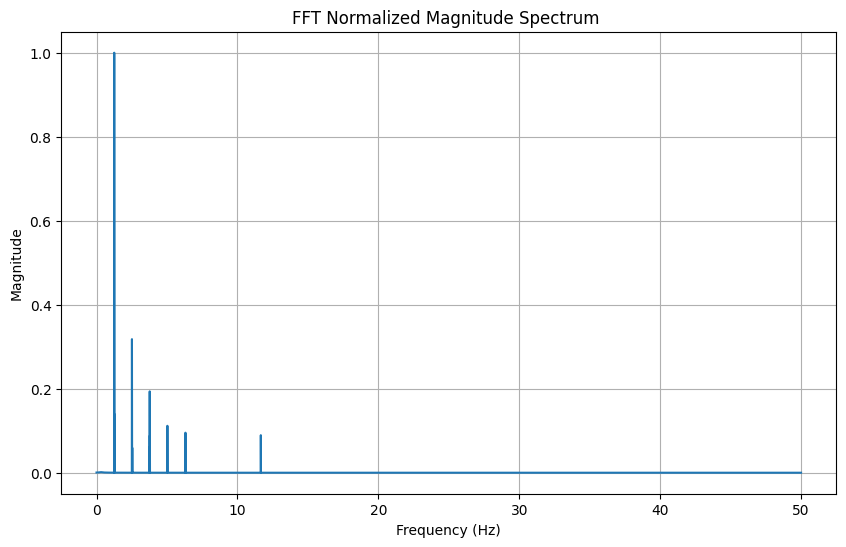

In [23]:
df_filtered_corrected_results = fft_results(filtered_acceleration_x, filtered_acceleration_y, filtered_acceleration_z, sampling_rate)

In [24]:
def analyze_wavelet_spectrum(df: pd.DataFrame, acceleration_column: str, wavelet: str = 'cmor1.5-1.0',
                             min_scale: int = 1, max_scale: int = 100) -> None:
    """
    Applies Continuous Wavelet Transform (CWT) to filtered acceleration data,
    calculates the average spectrum, and visualizes the time-frequency-magnitude spectrum.

    Args:
        df: DataFrame with 'Time' and at least one acceleration column.
        acceleration_column: Name of the acceleration column to analyze.
        wavelet: Wavelet function to use.
        min_scale: Minimum scale for the wavelet transform.
        max_scale: Maximum scale for the wavelet transform.

    Returns:
        None (displays the interactive 3D plot).
    """
    # Validaciones
    if acceleration_column not in df.columns:
        raise ValueError(f"Column '{acceleration_column}' not found in DataFrame.")
    if 'Time' not in df.columns:
        raise ValueError("The DataFrame must contain a 'Time' column.")

    # Calcular paso de tiempo y frecuencia de muestreo
    time_diffs = np.diff(df['Time'])
    time_step = np.mean(time_diffs)

    if time_step <= 0:
        raise ValueError("Invalid time step. Check if 'Time' column is monotonically increasing.")

    sampling_rate = 1 / time_step

    # Definir escalas y aplicar CWT
    scales = np.arange(min_scale, max_scale + 1)
    coefficients, frequencies = pywt.cwt(df[acceleration_column], scales, wavelet, time_step)

    # Espectro de magnitudes
    spectrum = np.abs(coefficients)

    # Valores mínimos y máximos para los sliders
    time_min, time_max = df['Time'].min(), df['Time'].max()
    freq_min, freq_max = frequencies.min(), frequencies.max()

    # Función para la visualización
    def plot_wavelet_spectrum(elevation=30, rotation=30, label_size=10, label_offset=0.1,
                              min_time=time_min, max_time=time_max, 
                              min_frequency=freq_min, max_frequency=freq_max):
        # Filtrar el rango de tiempo y frecuencia
        mask_x = (df['Time'] >= min_time) & (df['Time'] <= max_time)
        mask_y = (frequencies >= min_frequency) & (frequencies <= max_frequency)

        time_filtered = df['Time'][mask_x].values
        frequencies_filtered = frequencies[mask_y]
        spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

        # Crear la malla para el gráfico
        X, Y = np.meshgrid(time_filtered, frequencies_filtered)

        # Verificar dimensiones
        if X.shape != spectrum_filtered.shape:
            print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_filtered.shape}")
            return

        # Crear la figura 3D
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, spectrum_filtered, cmap='viridis')

        ax.set_xlabel('Time (s)', fontsize=label_size, labelpad=label_offset)
        ax.set_ylabel('Frequency (Hz)', fontsize=label_size, labelpad=label_offset)
        ax.set_zlabel('Magnitude', fontsize=label_size, labelpad=label_offset)
        ax.set_title('Time - Frequency - Magnitude Wavelet Spectrum', fontsize=label_size)
        ax.view_init(elev=elevation, azim=rotation)
        plt.show()

    # Crear controles interactivos
    widgets.interact(
        plot_wavelet_spectrum,
        elevation=(0, 360, 10),
        rotation=(0, 360, 10),
        label_size=(6, 32, 2),
        label_offset=(-0.25, 0.25, 0.01),
        min_time=(time_min, time_max, (time_max - time_min) / 100),
        max_time=(time_min, time_max, (time_max - time_min) / 100),
        min_frecuency=(freq_min, freq_max, (freq_max - freq_min) / 50),
        max_frequency=(freq_min, freq_max, (freq_max - freq_min) / 50)
    )

In [25]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from ipywidgets import widgets

def analyze_wavelet_spectrum(df: pd.DataFrame, acceleration_column: str, wavelet: str = 'cmor1.5-1.0',
                             min_scale: int = 1, max_scale: int = 100) -> None:
    """
    Applies Continuous Wavelet Transform (CWT) to filtered acceleration data,
    calculates the average spectrum, and visualizes the time-frequency-magnitude spectrum.

    Args:
        df: DataFrame with 'Time' and at least one acceleration column.
        acceleration_column: Name of the acceleration column to analyze.
        wavelet: Wavelet function to use.
        min_scale: Minimum scale for the wavelet transform.
        max_scale: Maximum scale for the wavelet transform.

    Returns:
        None (displays the interactive 3D plot).
    """
    # Validations
    if acceleration_column not in df.columns:
        raise ValueError(f"Column '{acceleration_column}' not found in DataFrame.")
    if 'Time' not in df.columns:
        raise ValueError("The DataFrame must contain a 'Time' column.")

    # Calculate time step and sampling rate
    time_diffs = np.diff(df['Time'])
    time_step = np.mean(time_diffs)

    if time_step <= 0:
        raise ValueError("Invalid time step. Check if 'Time' column is monotonically increasing.")

    sampling_rate = 1 / time_step

    # Define scales and apply CWT
    scales = np.arange(min_scale, max_scale + 1)
    coefficients, frequencies = pywt.cwt(df[acceleration_column], scales, wavelet, time_step)

    # Magnitude spectrum
    spectrum = np.abs(coefficients)

    # Min and max values for sliders
    time_min, time_max = df['Time'].min(), df['Time'].max()
    freq_min, freq_max = frequencies.min(), frequencies.max()

    # Function for visualization
    def plot_wavelet_spectrum(elevation=30, rotation=30, label_size=10, label_offset=0.1,
                              min_time=time_min, max_time=time_max, 
                              min_frequency=freq_min, max_frequency=freq_max):
        # Filter time and frequency range
        mask_x = (df['Time'] >= min_time) & (df['Time'] <= max_time)
        mask_y = (frequencies >= min_frequency) & (frequencies <= max_frequency)

        time_filtered = df['Time'][mask_x].values
        frequencies_filtered = frequencies[mask_y]
        spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

        # Create mesh for the plot
        X, Y = np.meshgrid(time_filtered, frequencies_filtered)

        # Verify dimensions
        if X.shape != spectrum_filtered.shape:
            print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_filtered.shape}")
            return

        # Create 3D figure
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, spectrum_filtered, cmap='viridis')

        ax.set_xlabel('Time (s)', fontsize=label_size, labelpad=label_offset)
        ax.set_ylabel('Frequency (Hz)', fontsize=label_size, labelpad=label_offset)
        ax.set_zlabel('Magnitude', fontsize=label_size, labelpad=label_offset)
        ax.set_title('Time - Frequency - Magnitude Wavelet Spectrum', fontsize=label_size)
        ax.view_init(elev=elevation, azim=rotation)
        plt.show()

    # Create interactive controls
    widgets.interact(
        plot_wavelet_spectrum,
        elevation=(0, 360, 10),
        rotation=(0, 360, 10),
        label_size=(6, 32, 2),
        label_offset=(-0.25, 0.25, 0.01),
        min_time=(time_min, time_max, (time_max - time_min) / 100),
        max_time=(time_min, time_max, (time_max - time_min) / 100),
        min_frequency=(freq_min, freq_max, (freq_max - freq_min) / 50),
        max_frequency=(freq_min, freq_max, (freq_max - freq_min) / 50)
    )

In [26]:
df

,Time,X Acceleration,Y Acceleration,Z Acceleration,X Acceleration baseline corrected,Y Acceleration baseline corrected,Z Acceleration baseline corrected,X Filtered Acceleration,Y Filtered Acceleration,Z Filtered Acceleration
0,0.01,-0.000169,-0.001170,-0.001292,-0.000048,-0.000912,-0.001840,0.000041,-0.000822,-0.000533
1,0.02,-0.000088,-0.000844,-0.001239,0.000033,-0.000587,-0.001787,0.000062,-0.000678,-0.000709
2,0.03,-0.000051,-0.000383,-0.001214,0.000070,-0.000126,-0.001763,0.000044,-0.000775,-0.000835
3,0.04,-0.000218,-0.000874,-0.001648,-0.000097,-0.000617,-0.002197,0.000022,-0.000962,-0.000884
4,0.05,-0.000159,-0.000841,-0.001586,-0.000039,-0.000583,-0.002134,0.000048,-0.000694,-0.000880
...,...,...,...,...,...,...,...,...,...,...
67103,671.04,0.000054,-0.000344,0.000950,0.000076,-0.000103,0.000065,0.000076,-0.000307,-0.000753
67104,671.05,0.000043,-0.000316,0.001028,0.000065,-0.000076,0.000142,0.000098,-0.000591,-0.000528
67105,671.06,0.000116,-0.000350,0.000916,0.000138,-0.000109,0.000031,0.000070,-0.001131,-0.000356
67106,671.07,0.000193,-0.000417,0.000813,0.000214,-0.000176,-0.000073,0.000077,-0.001224,-0.000300


In [27]:
analyze_wavelet_spectrum(df = df, acceleration_column = 'X Filtered Acceleration', wavelet = 'morl',
                             min_scale = 1, max_scale = 100)

interactive(children=(IntSlider(value=30, description='elevation', max=360, step=10), IntSlider(value=30, desc…

Time extent: 0.01 671.08
Frequency extent: 0.7874015748031495 100.0


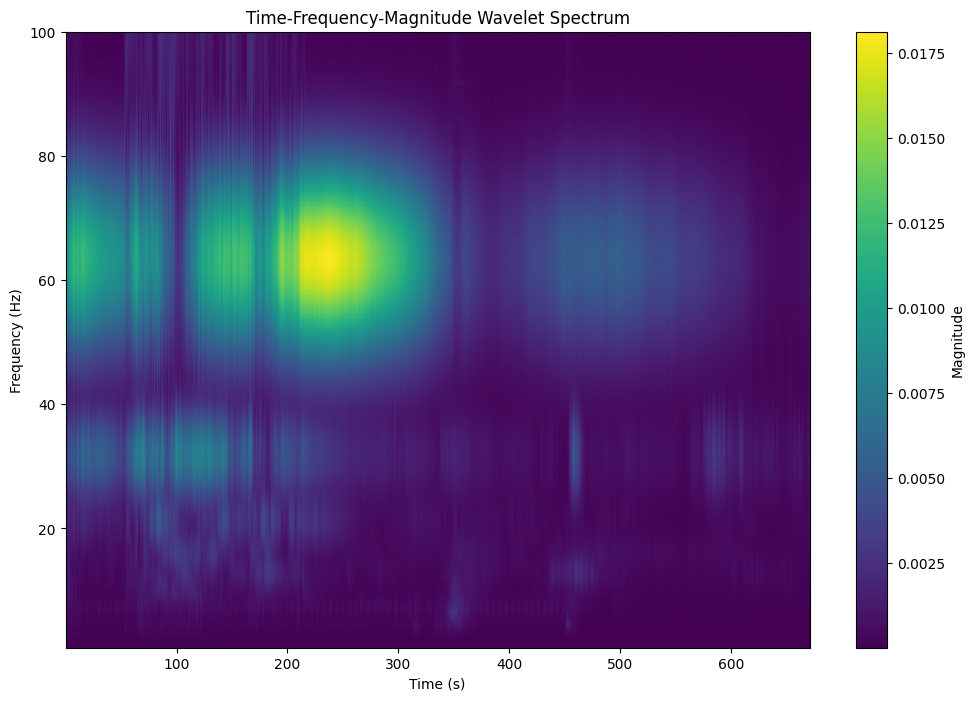

In [28]:
# Define the wavelet and the range of scales
wavelet = 'cmor1.5-1.0'
sampling_rate = 100
sampling_period = 1 / sampling_rate  # Sampling period
scales = np.arange(1, 128)

# Apply the CWT to each axis of acceleration
time = df['Time']
coefficients_x, frequencies_x = pywt.cwt(df['X Acceleration'], scales, wavelet, sampling_period)
coefficients_y, frequencies_y = pywt.cwt(df['Y Acceleration'], scales, wavelet, sampling_period)
coefficients_z, frequencies_z = pywt.cwt(df['Z Acceleration'], scales, wavelet, sampling_period)

# Calculate the average spectrum
average_spectrum = np.sqrt((np.abs(coefficients_x)**2 + np.abs(coefficients_y)**2 + np.abs(coefficients_z)**2) / 3)

# Debug: Print the extent values
print("Time extent:", time.min(), time.max())
print("Frequency extent:", frequencies_x.min(), frequencies_x.max())

# Visualize the time-frequency-magnitude spectrum
plt.figure(figsize=(12, 8))
plt.imshow(average_spectrum, extent=[time.min(), time.max(), frequencies_x.min(), frequencies_x.max()],
           aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency-Magnitude Wavelet Spectrum')
plt.show()